# **EDA**

## Objectives

* To perform exploratory data analysis

## Inputs

* The csv file "pollution_us_2012_2016-population-weather.csv" 

## Outputs

* Various plots (histogram, box plot, scatter plot etc.) to understand the distribution and correlation between variables, along with statistical tests

---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'c:\\Users\\sonia\\Documents\\VS Studio Projects\\US_Air_Pollution_Team_2\\jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [40]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


In [2]:
os.chdir(r"c:\Users\sonia\Documents\VS Studio Projects\US_Air_Pollution_Team_2")

os.getcwd()

'c:\\Users\\sonia\\Documents\\VS Studio Projects\\US_Air_Pollution_Team_2'

Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'c:\\Users\\sonia\\Documents\\VS Studio Projects\\US_Air_Pollution_Team_2'

---

## Required Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import QuantileTransformer
from feature_engine.transformation import YeoJohnsonTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor 
from xgboost import XGBRegressor

---

## Load the Dataset

In [100]:
df = pd.read_csv('Dataset/EDA/pollution_us_2012_2016-population-weather.csv') 
pd.set_option("display.max_columns", None)
df.head()


,State,County,City,Date Local,NO2 Mean,NO2 1st Max Value,NO2 1st Max Hour,NO2 AQI,O3 Mean,O3 1st Max Value,O3 1st Max Hour,O3 AQI,SO2 Mean,SO2 1st Max Value,SO2 1st Max Hour,SO2 AQI,CO Mean,CO 1st Max Value,CO 1st Max Hour,CO AQI,Population,Latitude,Longitude,tmax,prcp,wspd,pres,Month,Year,AQI
0,Arizona,Pima,Tucson,2012-01-01,17.716667,31.0,0,29,0.013667,0.030,10,25,0.254167,0.5,19,0.0,0.336842,0.6,5,7.0,542649,31.9681,-111.7806,26.7,0.0,17.6,1022.2,January,2012,29.0
1,Arizona,Pima,Tucson,2012-01-02,15.062500,30.6,18,28,0.015083,0.030,10,25,0.200000,0.6,19,0.0,0.225000,0.4,23,5.0,542649,31.9681,-111.7806,24.4,0.0,27.4,1023.2,January,2012,28.0
2,Arizona,Pima,Tucson,2012-01-03,21.643478,31.0,18,29,0.011417,0.026,9,22,0.295455,0.7,8,0.0,0.295833,0.4,0,5.0,542649,31.9681,-111.7806,26.1,0.0,10.8,1023.2,January,2012,29.0
3,Arizona,Pima,Tucson,2012-01-04,25.041668,37.8,10,35,0.009208,0.020,10,17,0.737500,2.1,19,3.0,0.345833,0.5,12,6.0,542649,31.9681,-111.7806,24.4,0.0,9.0,1024.2,January,2012,35.0
4,Arizona,Pima,Tucson,2012-01-05,21.981817,37.1,17,35,0.013042,0.031,9,26,0.330435,0.8,21,0.0,0.291667,0.6,23,7.0,542649,31.9681,-111.7806,23.9,0.0,9.7,1020.9,January,2012,35.0


In [101]:
df['Date Local'] = pd.to_datetime(df['Date Local'])

---

## Keping Cities with Enough Data for Modelling

In [102]:
df["City"].nunique()

43

In [103]:
# 2. Drop rows with invalid dates (if any)
bad_dates = df['Date Local'].isna().sum()
print(f"Rows with invalid dates: {bad_dates}")

# 3. Sort
df = df.sort_values(['City', 'Date Local']).reset_index(drop=True)

# 4. Quick checks
print(df[['City','Date Local']].groupby('City').agg(['min','max']).head())

Rows with invalid dates: 0
            Date Local           
                   min        max
City                             
Albuquerque 2012-01-01 2015-12-31
Alexandria  2012-03-31 2012-08-21
Austin      2012-11-30 2014-07-01
Birmingham  2013-12-01 2016-05-31
Blaine      2012-03-13 2015-12-28


In [104]:
# Define full expected date range
full_range = pd.date_range(start='2012-01-01', end='2016-05-31')

# Count days per city
city_day_counts = df.groupby('City')['Date Local'].nunique()

# Expected number of days (including leap years)
expected_days = len(full_range)  # 1827 days total

# Identify which cities have full coverage
complete_cities = city_day_counts[city_day_counts == expected_days].index
incomplete_cities = city_day_counts[city_day_counts < expected_days].index

print(f"Cities with full data (2012–2016): {len(complete_cities)}")
print(f"Cities missing some days: {len(incomplete_cities)}\n")

# Optionally display which are incomplete and how many days they have
city_coverage = pd.DataFrame({
    'Days available': city_day_counts,
    'Missing days': expected_days - city_day_counts
}).sort_values('Days available', ascending=False)

city_coverage.head(20)  # shows top 20 cities by coverage

Cities with full data (2012–2016): 0
Cities missing some days: 43



,Days available,Missing days
City,,
New York,1573,40
El Paso,1553,60
Deer Park,1547,66
Houston,1515,98
Charlotte,1514,99
Dallas,1501,112
Victorville,1480,133
Albuquerque,1432,181
Concord,1427,186


In [105]:
city_day_counts = df.groupby("City")["Date Local"].nunique().reset_index(name="Days_available")

# Keep only cities with > 1400 days
cities_to_keep = city_day_counts[city_day_counts["Days_available"] > 1400]["City"].tolist()

# Filter main dataframe
df_filtered = df[df["City"].isin(cities_to_keep)].copy()

print(f"Keeping {len(cities_to_keep)} cities:")
print(cities_to_keep)

Keeping 11 cities:
['Albuquerque', 'Charlotte', 'Concord', 'Dallas', 'Deer Park', 'El Paso', 'Houston', 'New York', 'Oakland', 'San Pablo', 'Victorville']


In [106]:
df_filtered.head(2)

,State,County,City,Date Local,NO2 Mean,NO2 1st Max Value,NO2 1st Max Hour,NO2 AQI,O3 Mean,O3 1st Max Value,O3 1st Max Hour,O3 AQI,SO2 Mean,SO2 1st Max Value,SO2 1st Max Hour,SO2 AQI,CO Mean,CO 1st Max Value,CO 1st Max Hour,CO AQI,Population,Latitude,Longitude,tmax,prcp,wspd,pres,Month,Year,AQI
0,New Mexico,Bernalillo,Albuquerque,2012-01-01,21.091667,36.1,3,34,0.016375,0.031,9,26,0.770833,1.5,21,1.0,0.246154,0.6,23,7.0,564549,35.0448,-106.677,11.1,0.0,6.1,1033.0,January,2012,34.0
1,New Mexico,Bernalillo,Albuquerque,2012-01-02,31.093750,41.4,18,39,0.012000,0.025,9,21,1.091667,2.1,1,3.0,0.412500,0.7,23,8.0,564549,35.0448,-106.677,10.0,0.0,5.8,1035.9,January,2012,39.0


In [107]:
# Get the list of cities currently in df_filtered
cities = df_filtered["City"].unique()

# Compute min and max Date Local for each city
city_coverage = df_filtered.groupby("City")["Date Local"].agg(["min", "max"])

# Filter to only the cities in our current set (11 cities)
city_coverage = city_coverage.loc[cities]

print(df_filtered.shape)
print("Date coverage for each city:")
print(city_coverage)

(20146, 30)
Date coverage for each city:
                   min        max
City                             
Albuquerque 2012-01-01 2015-12-31
Charlotte   2012-01-01 2016-05-31
Concord     2012-01-01 2016-04-30
Dallas      2012-01-01 2016-03-31
Deer Park   2012-01-01 2016-04-30
El Paso     2012-01-01 2016-04-30
Houston     2012-01-01 2016-03-31
New York    2012-01-01 2016-04-30
Oakland     2012-01-01 2016-04-30
San Pablo   2012-01-01 2016-04-30
Victorville 2012-01-01 2016-03-31


---

## Addition of Lag and Rolling Features

In [108]:
# Sort by city and date
df_filtered = df_filtered.sort_values(["City", "Date Local"])

# Create lag features
for lag in [1, 2, 3]:
    df_filtered[f"AQI_lag{lag}"] = df_filtered.groupby("City")["AQI"].shift(lag)

# 7-day rolling mean of past AQI
df_filtered["AQI_rolling7"] = df_filtered.groupby("City")["AQI"].transform(lambda x: x.rolling(7).mean())

# 7-day ahead target
df_filtered["AQI_7d_ahead"] = df_filtered.groupby("City")["AQI"].shift(-7)

# Drop rows with NaN from lags, rolling mean, or 7-day ahead target
df_filtered = df_filtered.dropna(subset=["AQI_7d_ahead", "AQI_rolling7", "AQI_lag1", "AQI_lag2", "AQI_lag3"]).reset_index(drop=True)

print(df_filtered.shape)
df_filtered.head(2)

(20003, 35)


,State,County,City,Date Local,NO2 Mean,NO2 1st Max Value,NO2 1st Max Hour,NO2 AQI,O3 Mean,O3 1st Max Value,O3 1st Max Hour,O3 AQI,SO2 Mean,SO2 1st Max Value,SO2 1st Max Hour,SO2 AQI,CO Mean,CO 1st Max Value,CO 1st Max Hour,CO AQI,Population,Latitude,Longitude,tmax,prcp,wspd,pres,Month,Year,AQI,AQI_lag1,AQI_lag2,AQI_lag3,AQI_rolling7,AQI_7d_ahead
0,New Mexico,Bernalillo,Albuquerque,2012-01-07,27.116667,39.1,20,37,0.010500,0.026,10,22,1.479167,2.8,8,3.0,0.483333,0.7,1,8.0,564549,35.0448,-106.677,12.8,0.0,8.6,1014.9,January,2012,37.0,49.0,40.0,34.0,39.000000,39.0
1,New Mexico,Bernalillo,Albuquerque,2012-01-08,16.020832,31.3,0,29,0.016042,0.029,12,25,0.600000,1.7,0,1.0,0.308333,0.8,1,9.0,564549,35.0448,-106.677,6.1,0.0,22.3,1017.3,January,2012,29.0,37.0,49.0,40.0,38.285714,35.0


---

## Add Cyclincal Month Features

In [109]:
# Convert month name to number if needed
month_mapping = {
    "January": 1, "February": 2, "March": 3, "April": 4,
    "May": 5, "June": 6, "July": 7, "August": 8,
    "September": 9, "October": 10, "November": 11, "December": 12
}

df_filtered['Month_num'] = df_filtered['Month'].map(month_mapping)

# Add cyclical features
df_filtered['month_sin'] = np.sin(2 * np.pi * df_filtered['Month_num'] / 12)
df_filtered['month_cos'] = np.cos(2 * np.pi * df_filtered['Month_num'] / 12)
df_filtered.head(2)

,State,County,City,Date Local,NO2 Mean,NO2 1st Max Value,NO2 1st Max Hour,NO2 AQI,O3 Mean,O3 1st Max Value,O3 1st Max Hour,O3 AQI,SO2 Mean,SO2 1st Max Value,SO2 1st Max Hour,SO2 AQI,CO Mean,CO 1st Max Value,CO 1st Max Hour,CO AQI,Population,Latitude,Longitude,tmax,prcp,wspd,pres,Month,Year,AQI,AQI_lag1,AQI_lag2,AQI_lag3,AQI_rolling7,AQI_7d_ahead,Month_num,month_sin,month_cos
0,New Mexico,Bernalillo,Albuquerque,2012-01-07,27.116667,39.1,20,37,0.010500,0.026,10,22,1.479167,2.8,8,3.0,0.483333,0.7,1,8.0,564549,35.0448,-106.677,12.8,0.0,8.6,1014.9,January,2012,37.0,49.0,40.0,34.0,39.000000,39.0,1,0.5,0.866025
1,New Mexico,Bernalillo,Albuquerque,2012-01-08,16.020832,31.3,0,29,0.016042,0.029,12,25,0.600000,1.7,0,1.0,0.308333,0.8,1,9.0,564549,35.0448,-106.677,6.1,0.0,22.3,1017.3,January,2012,29.0,37.0,49.0,40.0,38.285714,35.0,1,0.5,0.866025


---

## Drop Unwanted Variables

In [110]:
keep_col = ["State",
            "County",
            "City",
            "Date Local",
            "NO2 Mean",
            "NO2 1st Max Hour",
            "O3 Mean",
            "O3 1st Max Hour",
            "SO2 Mean",
            "SO2 1st Max Hour",
            "CO Mean",
            "CO 1st Max Hour",
            "Population",
            "Latitude",
            "Longitude",
            "tmax",
            "prcp",
            "wspd",
            "pres",
            "Year",
            "AQI",
            "AQI_lag1",
            "AQI_lag2",
            "AQI_lag3",
            "AQI_rolling7",
            "AQI_7d_ahead",
            "month_sin",
            "month_cos" 
]

df_keep = df_filtered[keep_col]
df_keep.head()

,State,County,City,Date Local,NO2 Mean,NO2 1st Max Hour,O3 Mean,O3 1st Max Hour,SO2 Mean,SO2 1st Max Hour,CO Mean,CO 1st Max Hour,Population,Latitude,Longitude,tmax,prcp,wspd,pres,Year,AQI,AQI_lag1,AQI_lag2,AQI_lag3,AQI_rolling7,AQI_7d_ahead,month_sin,month_cos
0,New Mexico,Bernalillo,Albuquerque,2012-01-07,27.116667,20,0.010500,10,1.479167,8,0.483333,1,564549,35.0448,-106.677,12.8,0.0,8.6,1014.9,2012,37.0,49.0,40.0,34.0,39.000000,39.0,0.5,0.866025
1,New Mexico,Bernalillo,Albuquerque,2012-01-08,16.020832,0,0.016042,12,0.600000,0,0.308333,1,564549,35.0448,-106.677,6.1,0.0,22.3,1017.3,2012,29.0,37.0,49.0,40.0,38.285714,35.0,0.5,0.866025
2,New Mexico,Bernalillo,Albuquerque,2012-01-09,18.456522,21,0.014208,11,0.604167,16,0.237500,23,564549,35.0448,-106.677,8.3,0.0,10.8,1024.5,2012,35.0,29.0,37.0,49.0,37.714286,26.0,0.5,0.866025
3,New Mexico,Bernalillo,Albuquerque,2012-01-10,30.562500,7,0.009833,9,1.816667,8,0.495833,10,564549,35.0448,-106.677,11.1,0.0,5.0,1020.7,2012,43.0,35.0,29.0,37.0,38.142857,35.0,0.5,0.866025
4,New Mexico,Bernalillo,Albuquerque,2012-01-11,20.237500,6,0.021417,11,1.154167,7,0.395833,7,564549,35.0448,-106.677,11.1,0.0,13.7,1015.9,2012,36.0,43.0,35.0,29.0,38.428571,41.0,0.5,0.866025


In [111]:
df_keep = df_keep.copy()
df_keep['Date Local'] = pd.to_datetime(df_keep['Date Local'])

---

## Split into Train and Test Sets

In [112]:
# Set train: 2012-01-01 to 2014-12-31
train_end = pd.Timestamp("2014-12-31")

# Set test: 2015-01-01 to 2016-05-31 (your last date)
test_start = pd.Timestamp("2015-01-01")
test_end = pd.Timestamp("2016-05-31")

In [113]:
train_df = df_keep[df_keep["Date Local"] <= train_end]
test_df  = df_keep[(df_keep["Date Local"] >= test_start) & (df_keep["Date Local"] <= test_end)]

print(train_df.shape)
print(test_df.shape)

(14880, 28)
(5123, 28)


In [114]:
# Keep auxiliary columns for plotting
plot_test = test_df[["Date Local", "City"]].copy()

In [115]:
# Train: 2012-01-01 to 2014-12-31
X_train = train_df.drop(["AQI_7d_ahead", "Date Local"], axis=1)
y_train = train_df["AQI_7d_ahead"]

# Test: 2015-01-01 to 2016-05-31
X_test = test_df.drop(["AQI_7d_ahead", "Date Local"], axis=1)
y_test = test_df["AQI_7d_ahead"]

print(
    "* Train set:", X_train.shape, y_train.shape,
    "\n* Test set:", X_test.shape, y_test.shape
)

* Train set: (14880, 26) (14880,) 
* Test set: (5123, 26) (5123,)


---

## Pipeline

In [116]:
def PipelineOptimization(model, X, use_feature_selection=False):
    numeric_cols = X.select_dtypes(include="number").columns.tolist()
    categorical_cols = X.select_dtypes(include="object").columns.tolist()
    
    numeric_pipeline = Pipeline([("scaler", StandardScaler())])
    categorical_pipeline = Pipeline([("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))])
    
    preprocessor = ColumnTransformer([
        ("numeric", numeric_pipeline, numeric_cols),
        ("categorical", categorical_pipeline, categorical_cols)
    ])
    
    steps = [("preprocessor", preprocessor)]
    
    # Only add SelectFromModel if explicitly requested and model supports it
    if use_feature_selection and (hasattr(model, "coef_") or hasattr(model, "feature_importances_")):
        steps.append(("feat_selection", SelectFromModel(model)))
    
    steps.append(("model", model))
    
    return Pipeline(steps)

In [117]:
models = {
    "RandomForest": RandomForestRegressor(random_state=0),
    "GradientBoosting": GradientBoostingRegressor(random_state=0),
    "HGBoosting": HistGradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

In [118]:
param_grid = {
    "RandomForest": {},
    "GradientBoosting": {},
    "HGBoosting": {},
    "XGBRegressor": {},
}

In [119]:
# Use 3 folds; adjust based on your train set length
tscv = TimeSeriesSplit(n_splits=3)

In [120]:
results = {}

for name, model in models.items():
    print(f"\nRunning GridSearchCV for {name}...")
    
    pipe = PipelineOptimization(model, X_train, use_feature_selection=True)
    
    grid = GridSearchCV(
        pipe,
        param_grid[name],
        cv=tscv,
        scoring="neg_mean_absolute_error",
        n_jobs=-1
    )
    
    grid.fit(X_train, y_train)
    
    results[name] = {
        "best_params": grid.best_params_,
        "best_mae": -grid.best_score_
    }
    
    print(f"{name} best MAE (CV): {-grid.best_score_:.2f}")


Running GridSearchCV for RandomForest...
RandomForest best MAE (CV): 12.16

Running GridSearchCV for GradientBoosting...
GradientBoosting best MAE (CV): 11.25

Running GridSearchCV for HGBoosting...
HGBoosting best MAE (CV): 11.74

Running GridSearchCV for XGBRegressor...
XGBRegressor best MAE (CV): 12.42


In [ ]:
# Best model from GridSearchCV
best_model = grid.best_estimator_

# Best hyperparameters
best_params = grid.best_params_

# Best CV score (negative MAE, if scoring='neg_mean_absolute_error')
best_cv_mae = -grid.best_score_

print("Best CV MAE:", best_cv_mae)
print("Best parameters:", best_params)

Best CV MAE: 12.417289229874969
Best parameters: {}


In [123]:
pd.DataFrame(results).T.sort_values("best_mae")

,best_params,best_mae
GradientBoosting,{},11.245821
HGBoosting,{},11.739241
RandomForest,{},12.160557
XGBRegressor,{},12.417289


In [124]:
# 1Find the model with the lowest MAE
best_model_name = min(results, key=lambda x: results[x]["best_mae"])
best_mae = results[best_model_name]["best_mae"]
best_params = results[best_model_name]["best_params"]

print(f"Best model overall: {best_model_name}")
print(f"Best CV MAE: {best_mae:.3f}")
print("Best hyperparameters:", best_params)

Best model overall: GradientBoosting
Best CV MAE: 11.246
Best hyperparameters: {}


In [125]:
# Rebuild pipeline using the best model and params
best_estimator = models[best_model_name].set_params(**best_params)
best_pipeline = PipelineOptimization(best_estimator, X_train, use_feature_selection=False)

# Fit the model on the full training data
best_pipeline.fit(X_train, y_train)

# Predict on the test data
y_pred = best_pipeline.predict(X_test)

In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score

test_mae = mean_absolute_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)

print(f"Test MAE: {test_mae:.3f}")
print(f"Test R²: {test_r2:.3f}")

In [126]:
# Metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test MAE: {mae:.2f}")
print(f"Test MSE: {mse:.2f}")
print(f"Test R²: {r2:.2f}")

Test MAE: 9.69
Test MSE: 259.46
Test R²: 0.26


---

In [ ]:
def extract_feature_importances(pipeline, X, y, n_repeats=10, random_state=0):
    """
    Extract feature importances from a fitted pipeline, including SelectFromModel if present.
    
    Args:
        pipeline: fitted sklearn Pipeline
        X: DataFrame used for training/testing
        y: target array
        n_repeats: number of repetitions for permutation importance
        random_state: random state for reproducibility
    
    Returns:
        DataFrame with 'feature' and 'importance', sorted descending
    """
    # Extract preprocessor
    preprocessor = pipeline.named_steps['preprocessor']
    model = pipeline.named_steps['model']
    
    # Numeric feature names
    numeric_cols = preprocessor.transformers_[0][2]
    
    # Categorical feature names
    cat_pipe = preprocessor.transformers_[1][1]
    ohe = cat_pipe.named_steps['onehot']
    categorical_cols = ohe.get_feature_names_out(preprocessor.transformers_[1][2])
    
    all_features = list(numeric_cols) + list(categorical_cols)
    
    # Check if SelectFromModel is used
    if 'feat_selection' in pipeline.named_steps:
        selector = pipeline.named_steps['feat_selection']
        support_mask = selector.get_support()
        all_features = np.array(all_features)[support_mask]
        model_for_importance = selector.estimator_
    else:
        model_for_importance = model
    
    # Extract importances
    if hasattr(model_for_importance, 'feature_importances_'):
        importances = model_for_importance.feature_importances_
    elif hasattr(model_for_importance, 'coef_'):
        importances = abs(model_for_importance.coef_)
    else:
        # Permutation importance as fallback
        X_transformed = preprocessor.transform(X)
        if 'feat_selection' in pipeline.named_steps:
            # Reduce to selected features
            X_transformed = X_transformed[:, support_mask]
        perm = permutation_importance(
            model_for_importance, X_transformed, y, n_repeats=n_repeats, random_state=random_state
        )
        importances = perm.importances_mean
    
    df = pd.DataFrame({'feature': all_features, 'importance': importances})
    return df.sort_values('importance', ascending=False)

In [128]:
feat_df = extract_feature_importances(best_model, X_test, y_test)
print(feat_df.head(20))

                  feature  importance
37  County_San Bernardino    0.576518
20           AQI_rolling7    0.061685
22              month_cos    0.050117
9                Latitude    0.037986
10              Longitude    0.031878
8              Population    0.014744
2                 O3 Mean    0.014714
21              month_sin    0.013742
44           City_Houston    0.013585
15                   Year    0.013439
40           City_Concord    0.012950
26   State_North Carolina    0.010997
11                   tmax    0.010553
16                    AQI    0.009892
42         City_Deer Park    0.009755
14                   pres    0.009289
13                   wspd    0.008975
32          County_Dallas    0.007988
12                   prcp    0.007963
19               AQI_lag3    0.007531


In [129]:
def plot_top_features(feat_df, top_n=20, figsize=(10,6)):
    """
    Plot the top N features by importance.
    
    Args:
        feat_df: DataFrame with 'feature' and 'importance'
        top_n: number of top features to plot
        figsize: tuple for figure size
    """
    top_df = feat_df.head(top_n).sort_values('importance')
    
    plt.figure(figsize=figsize)
    plt.barh(top_df['feature'], top_df['importance'], color='skyblue')
    plt.xlabel("Importance")
    plt.title(f"Top {top_n} Features")
    plt.tight_layout()
    plt.show()

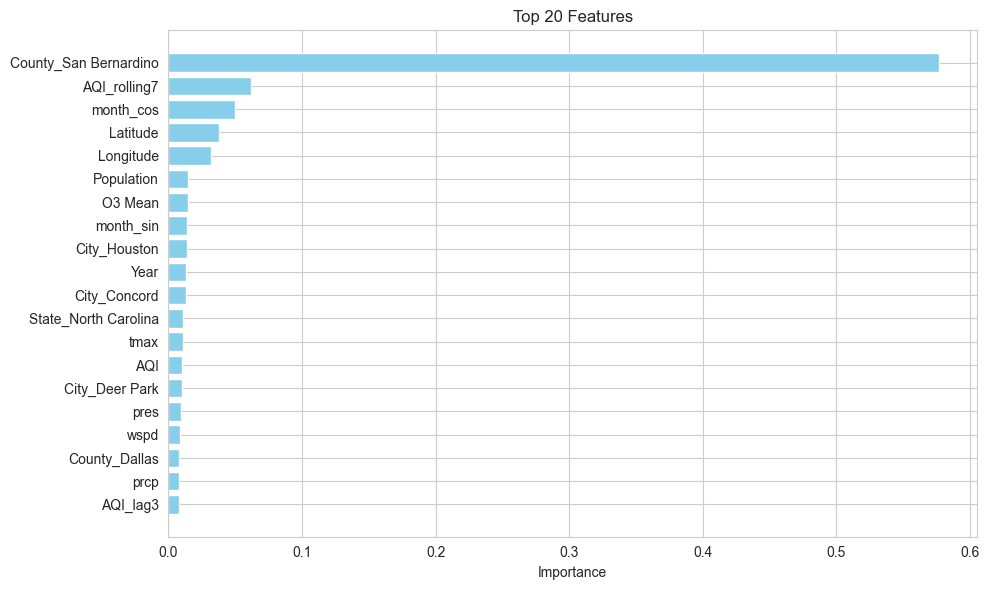

In [130]:
plot_top_features(feat_df, top_n=20)

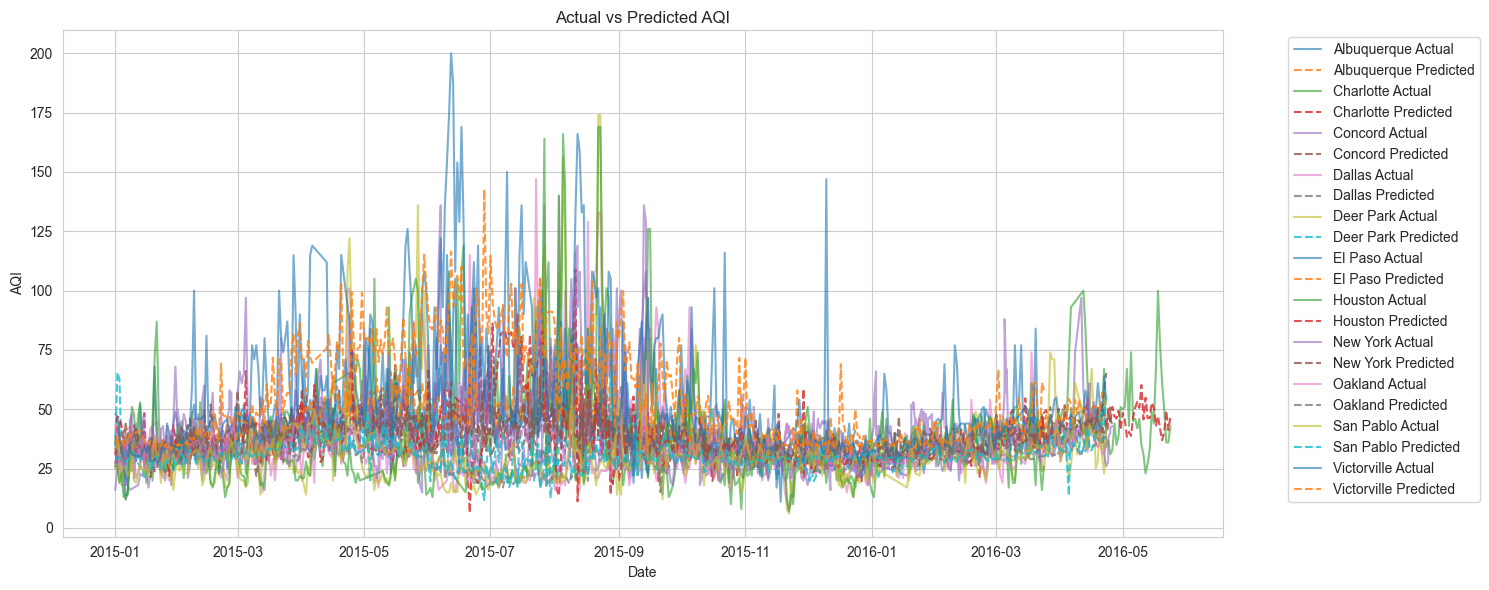

In [ ]:
# Make predictions
y_pred = best_model.predict(X_test)

# Create df_plot to compare actual vs predicted
df_plot = pd.DataFrame({
    "Date": test_df["Date Local"].reset_index(drop=True),
    "City": test_df["City"].reset_index(drop=True),
    "Actual": y_test.reset_index(drop=True),
    "Predicted": y_pred
})

# Plot
sns.set_style("whitegrid")
plt.figure(figsize=(15, 6))

# Plot all cities
for city in df_plot['City'].unique():
    city_data = df_plot[df_plot['City'] == city]
    plt.plot(city_data['Date'], city_data['Actual'], label=f"{city} Actual", alpha=0.6)
    plt.plot(city_data['Date'], city_data['Predicted'], label=f"{city} Predicted", alpha=0.8, linestyle='--')

plt.xlabel("Date")
plt.ylabel("AQI")
plt.title("Actual vs Predicted AQI")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


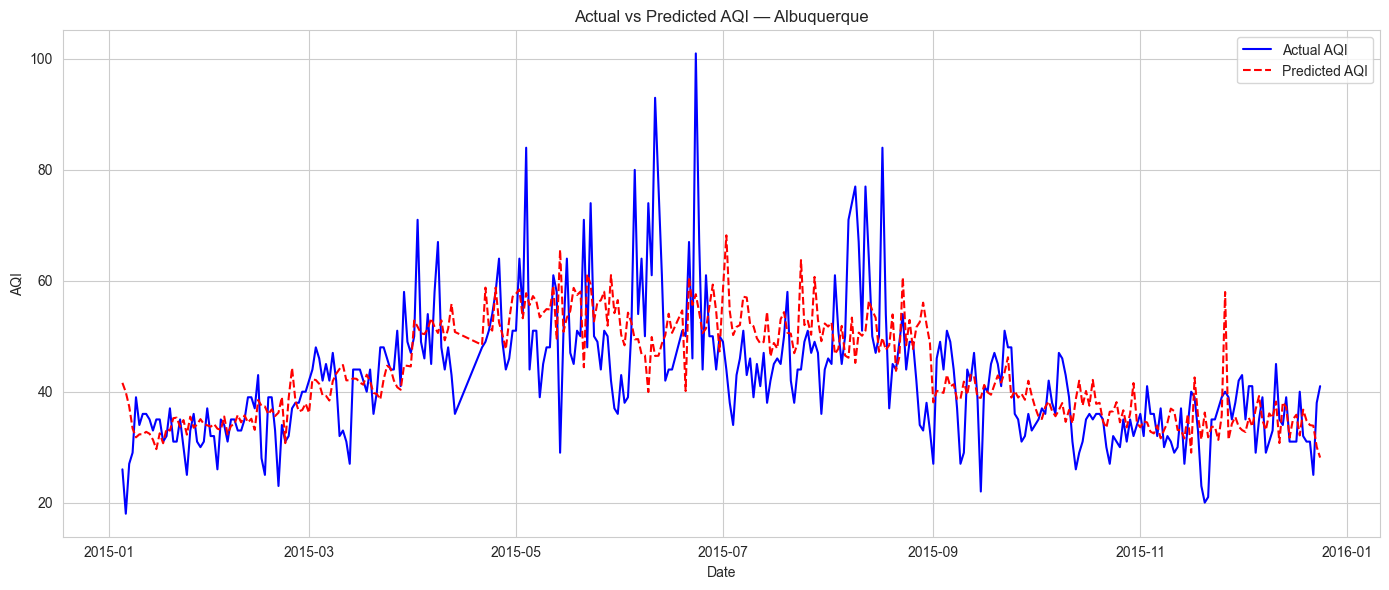

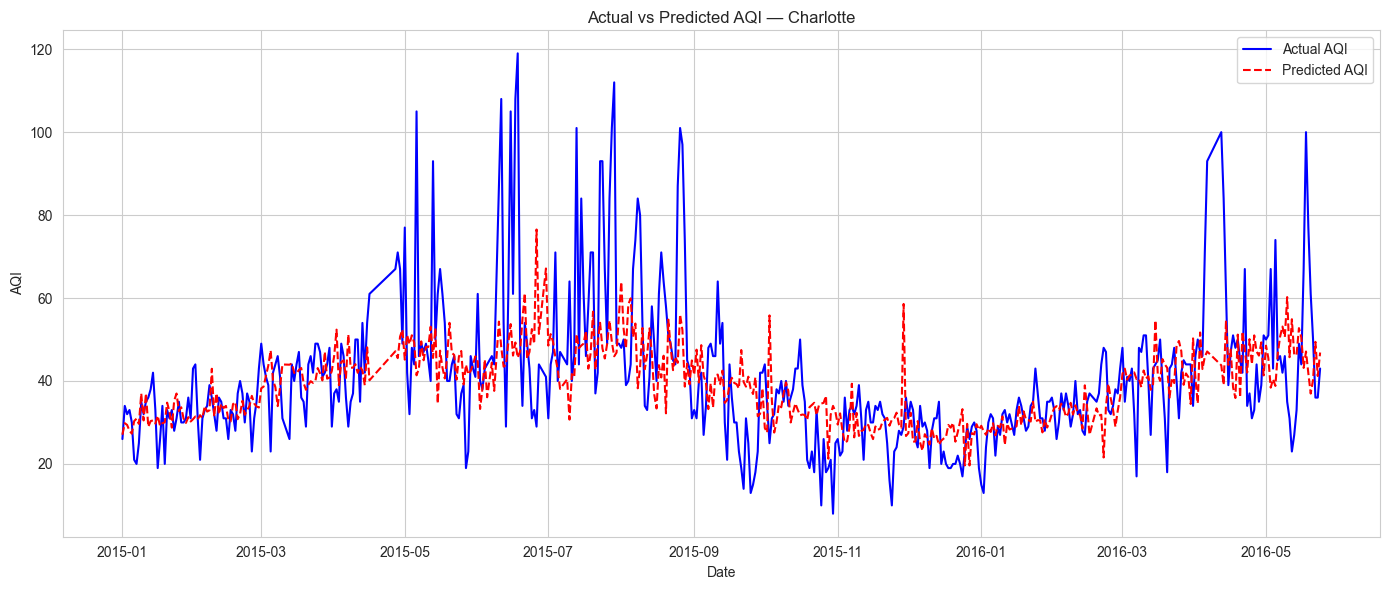

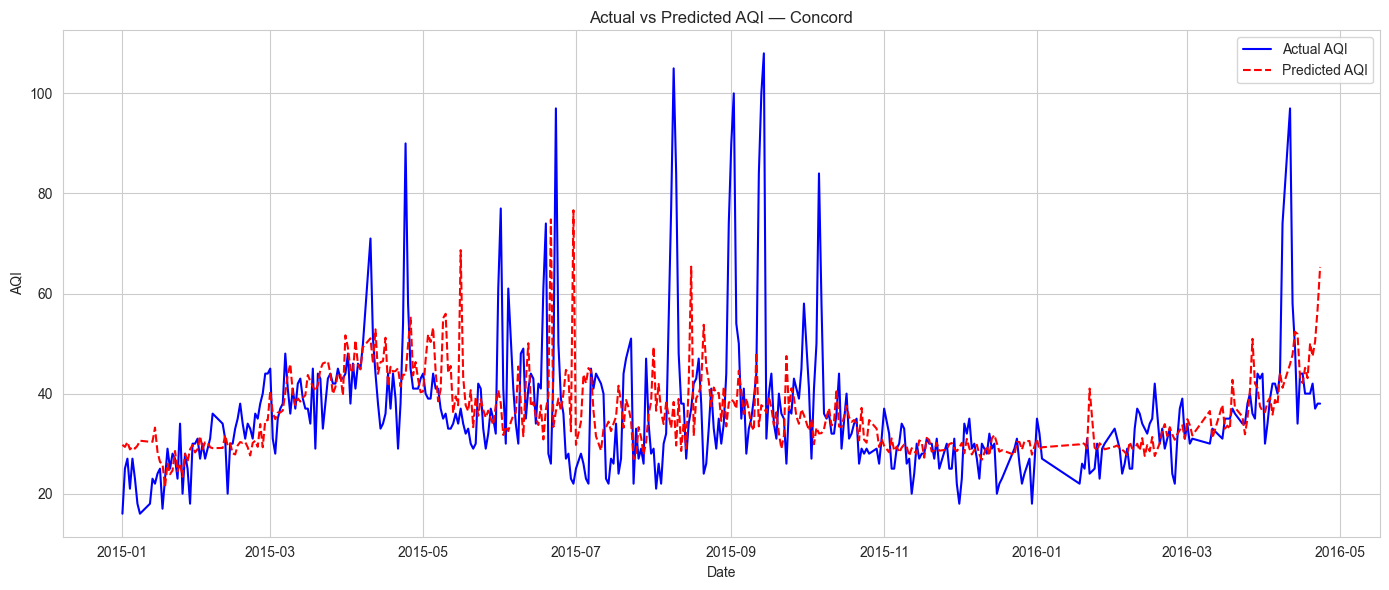

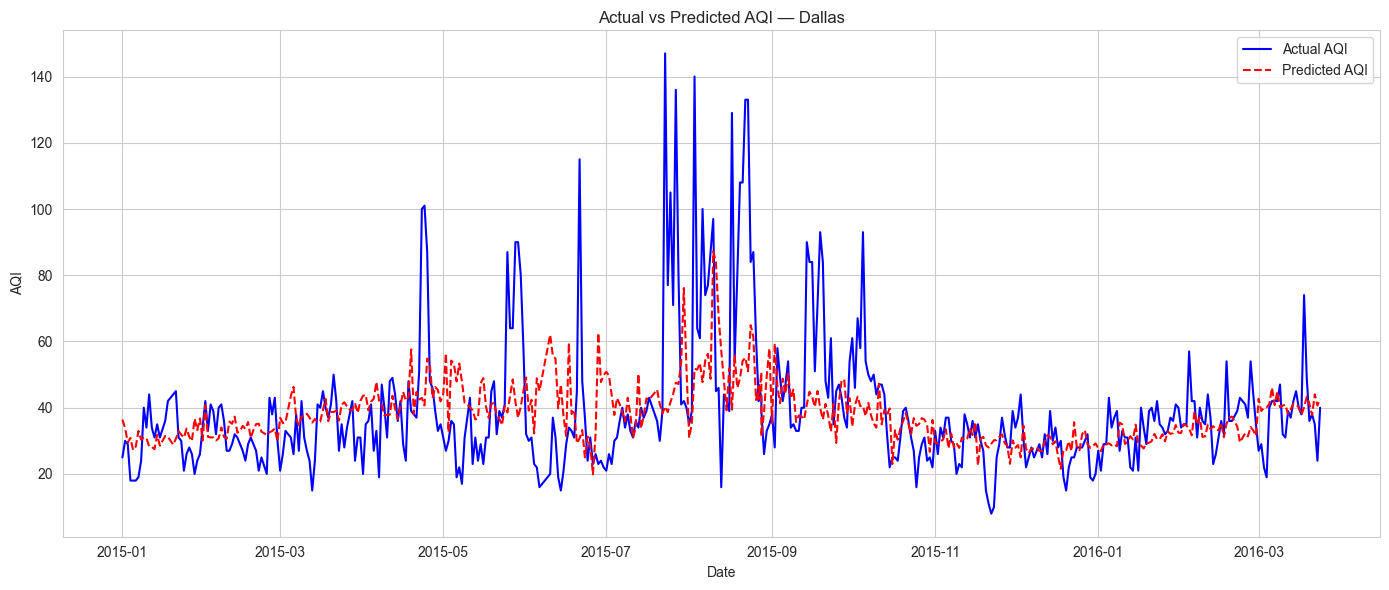

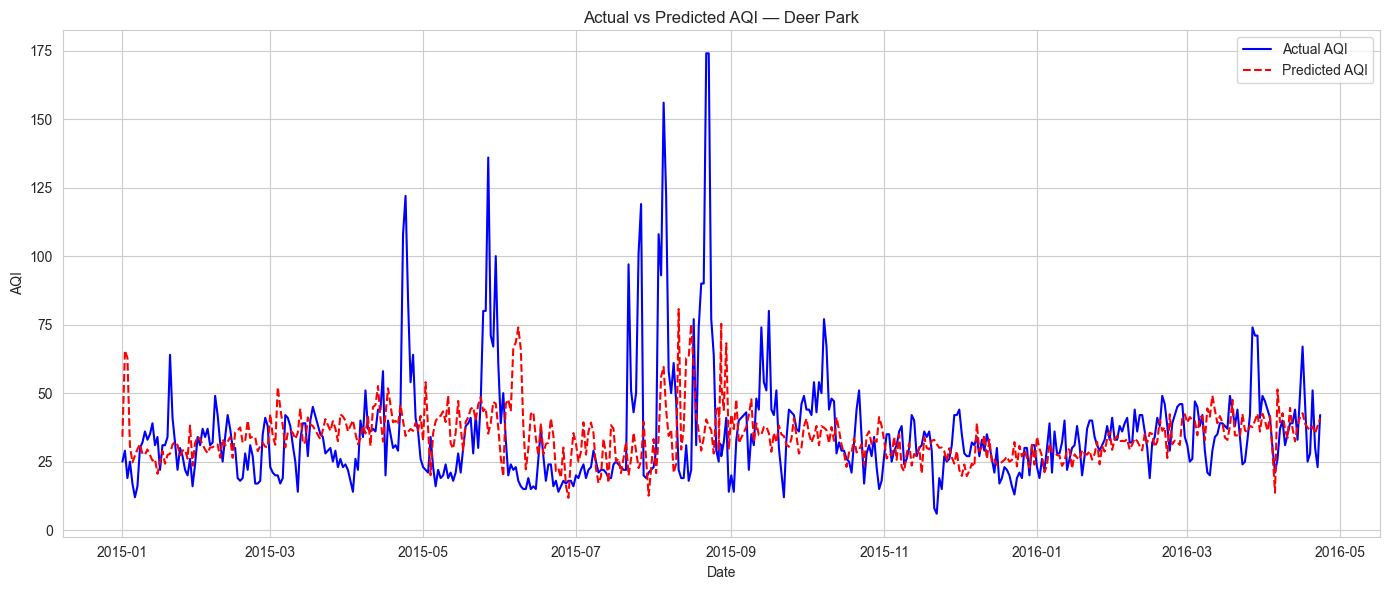

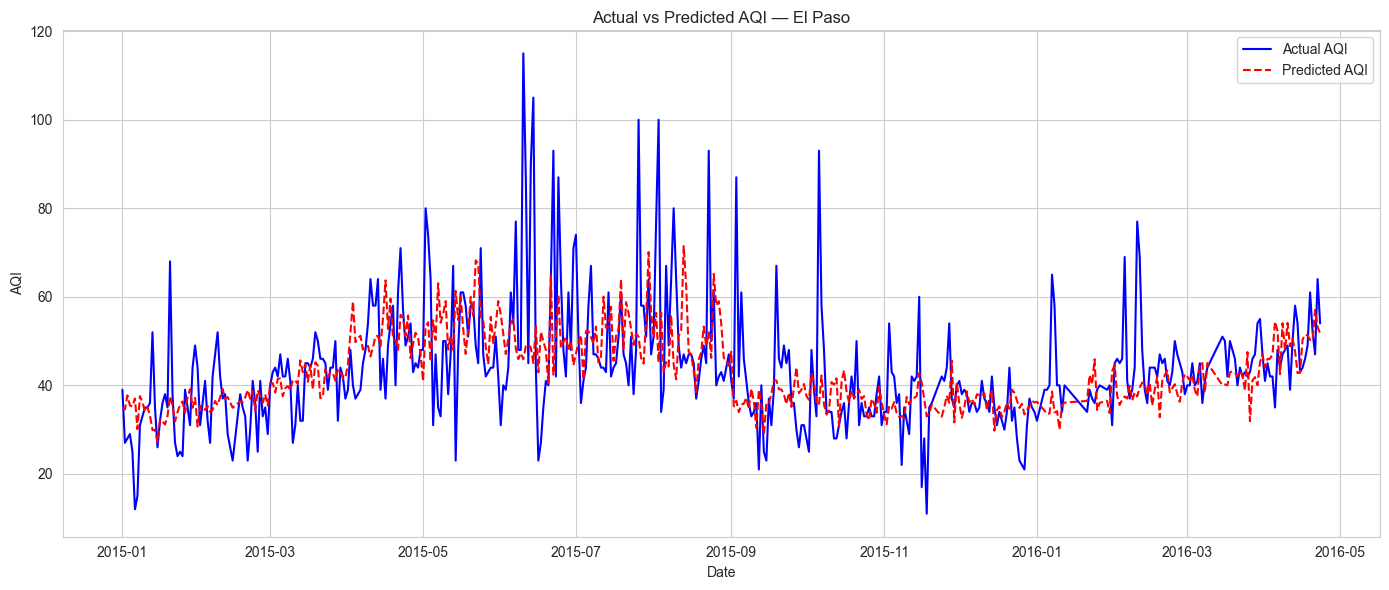

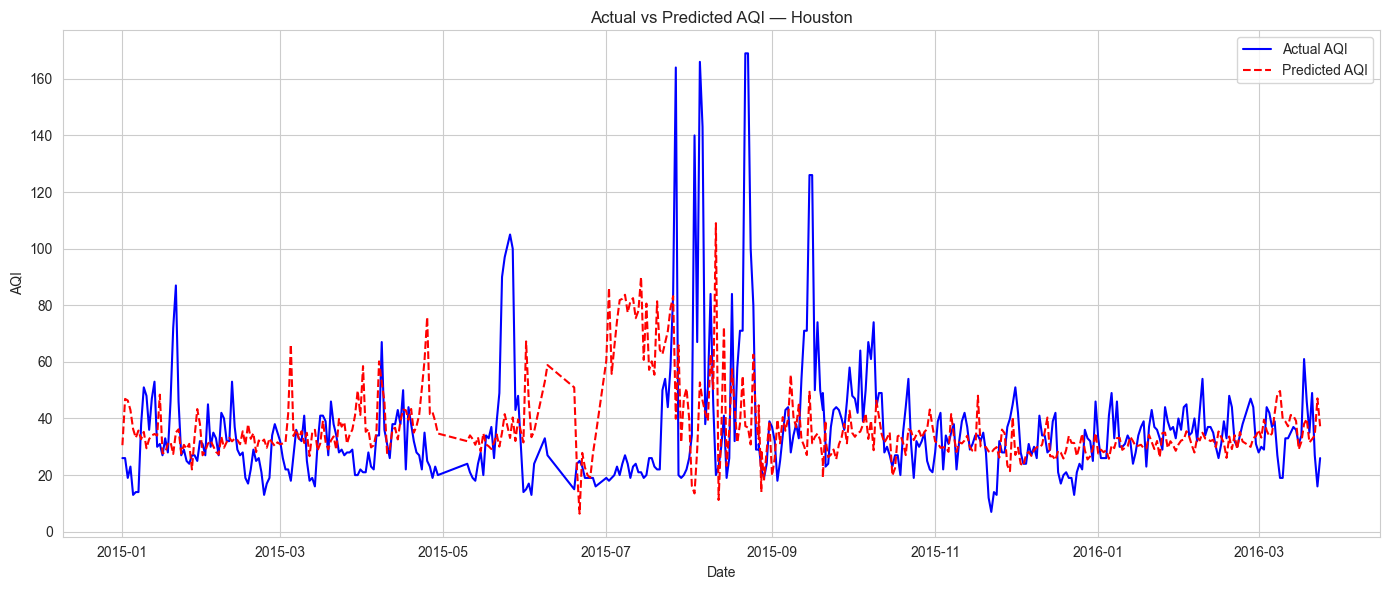

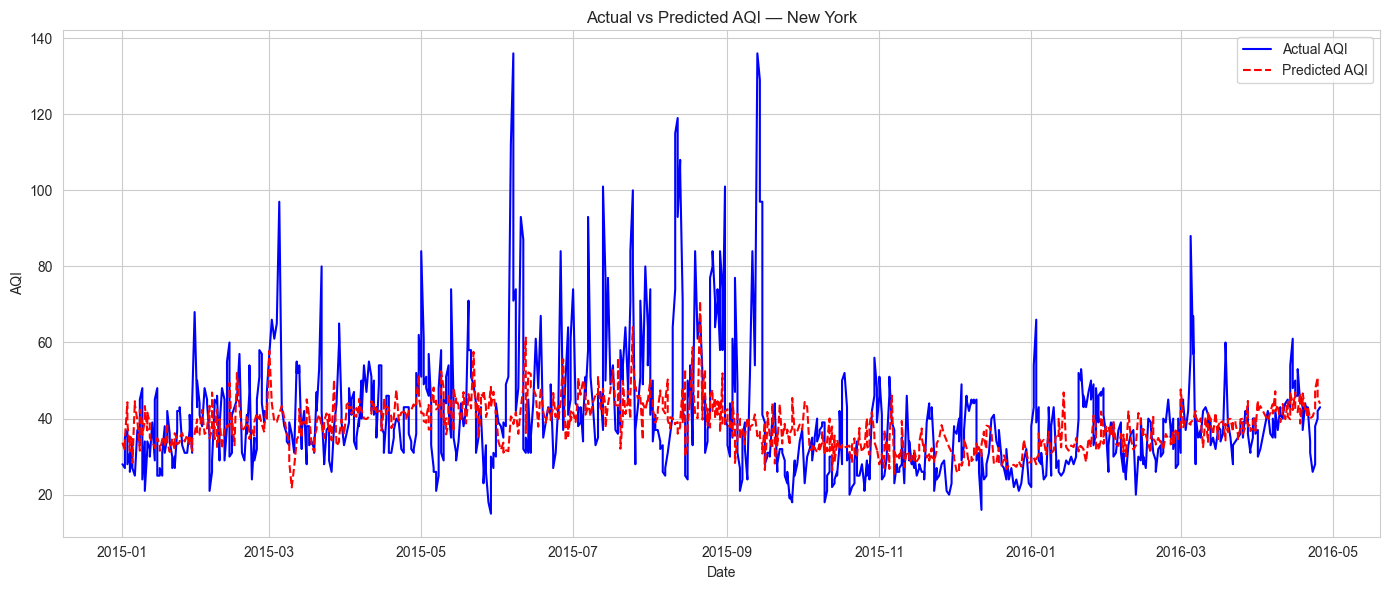

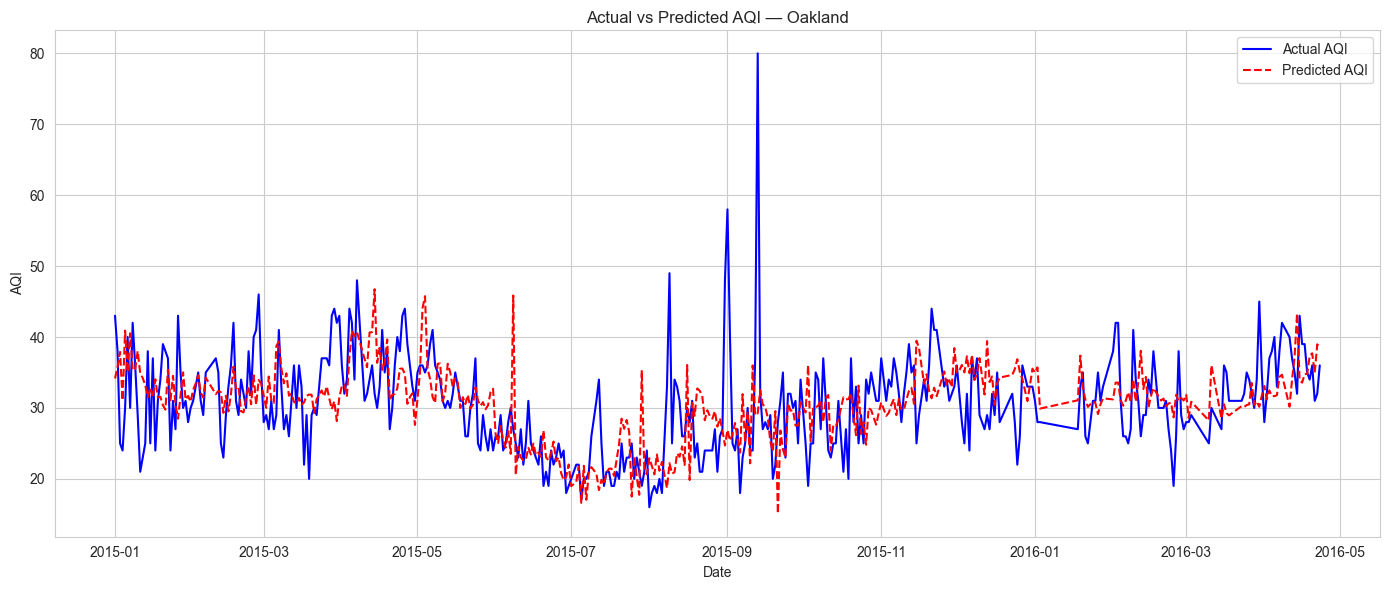

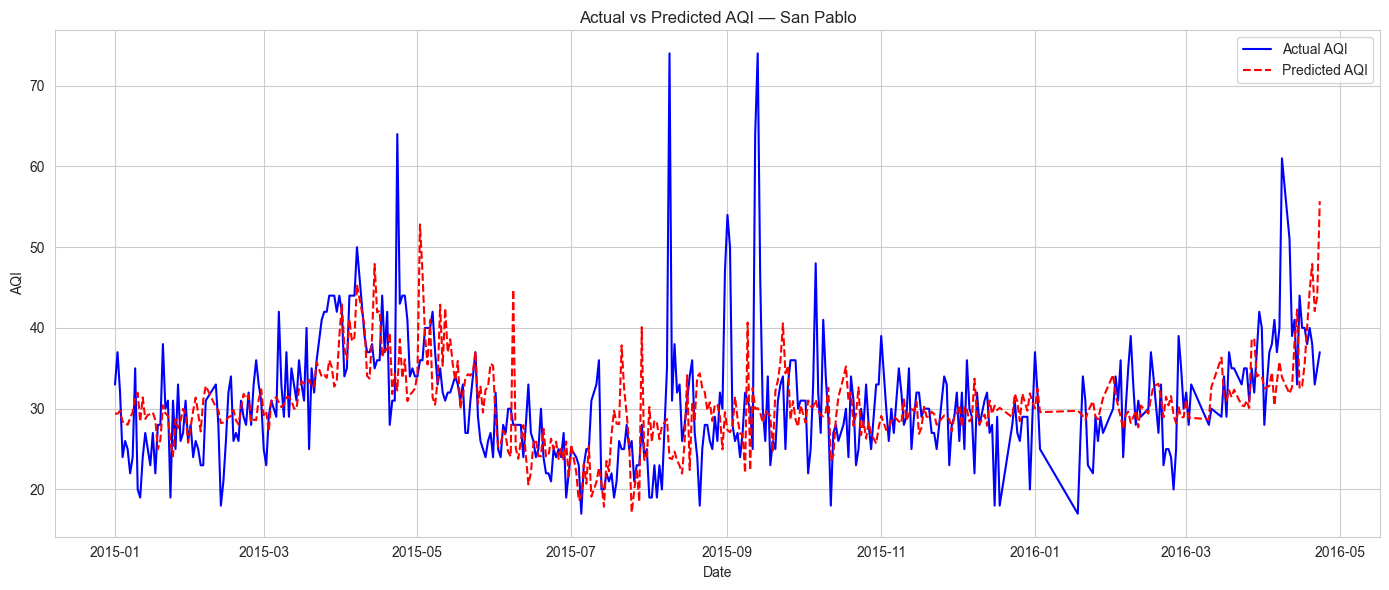

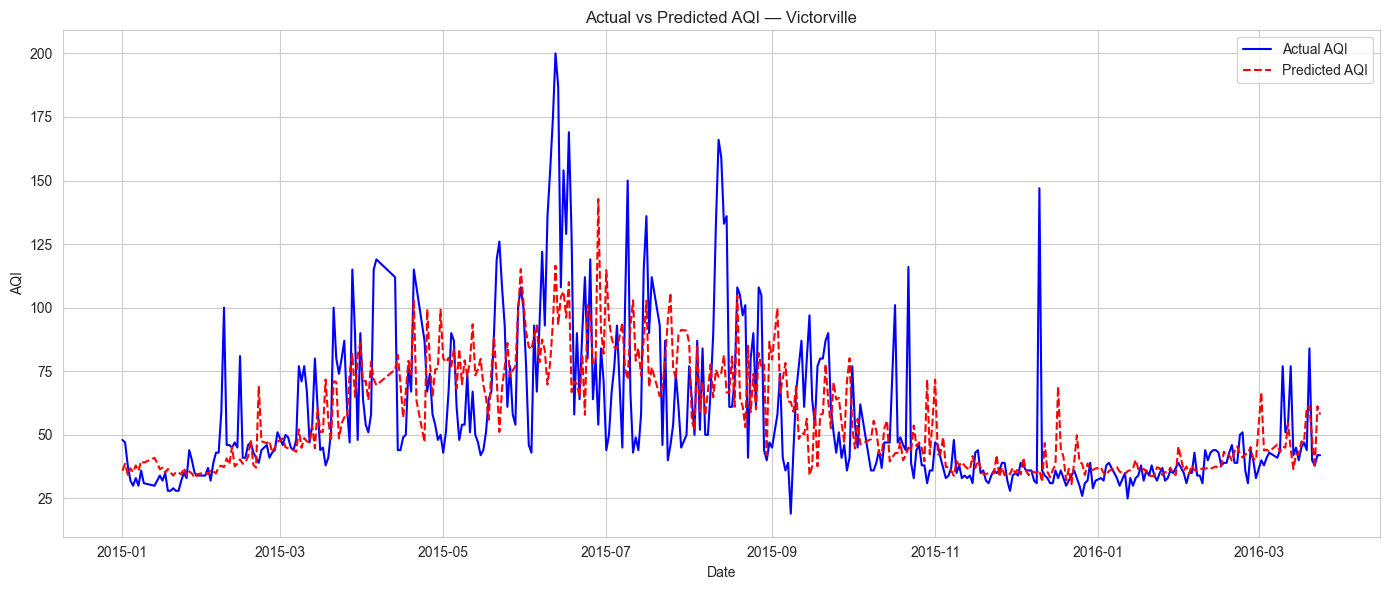

In [132]:
sns.set_style("whitegrid")

for city in df_plot["City"].unique():
    city_data = df_plot[df_plot["City"] == city]

    plt.figure(figsize=(14, 6))
    plt.plot(city_data["Date"], city_data["Actual"], label="Actual AQI", color="blue")
    plt.plot(city_data["Date"], city_data["Predicted"], label="Predicted AQI", color="red", linestyle="--")

    plt.xlabel("Date")
    plt.ylabel("AQI")
    plt.title(f"Actual vs Predicted AQI — {city}")
    plt.legend()
    plt.tight_layout()
    plt.show()

---

## Addition of Prediction and Residuals

In [133]:
# Make a copy to keep the original test_df intact
test_with_preds = test_df.copy()

# Add model predictions
test_with_preds["Predicted_AQI_7d_ahead"] = y_pred

# Add residuals (actual - predicted)
test_with_preds["Residual"] = test_with_preds["AQI_7d_ahead"] - test_with_preds["Predicted_AQI_7d_ahead"]

test_with_preds.head(2)

,State,County,City,Date Local,NO2 Mean,NO2 1st Max Hour,O3 Mean,O3 1st Max Hour,SO2 Mean,SO2 1st Max Hour,CO Mean,CO 1st Max Hour,Population,Latitude,Longitude,tmax,prcp,wspd,pres,Year,AQI,AQI_lag1,AQI_lag2,AQI_lag3,AQI_rolling7,AQI_7d_ahead,month_sin,month_cos,Predicted_AQI_7d_ahead,Residual
1074,New Mexico,Bernalillo,Albuquerque,2015-01-05,27.963636,21,0.007958,11,1.266667,8,0.608333,10,564549,35.0448,-106.677,7.8,0.0,6.1,1033.4,2015,39.0,27.0,26.0,37.0,32.857143,26.0,0.5,0.866025,41.596401,-15.596401
1075,New Mexico,Bernalillo,Albuquerque,2015-01-06,25.945833,20,0.014042,8,0.866667,7,0.487500,7,564549,35.0448,-106.677,13.3,0.0,10.8,1030.9,2015,38.0,39.0,27.0,26.0,33.571429,18.0,0.5,0.866025,39.910110,-21.910110


In [134]:
print(test_with_preds[["City", "Date Local", "AQI_7d_ahead", "Predicted_AQI_7d_ahead", "Residual"]].head())

print("Mean residual:", test_with_preds["Residual"].mean())
print("Residual standard deviation:", test_with_preds["Residual"].std())

             City Date Local  AQI_7d_ahead  Predicted_AQI_7d_ahead   Residual
1074  Albuquerque 2015-01-05          26.0               41.596401 -15.596401
1075  Albuquerque 2015-01-06          18.0               39.910110 -21.910110
1076  Albuquerque 2015-01-07          27.0               37.325718 -10.325718
1077  Albuquerque 2015-01-08          29.0               33.371067  -4.371067
1078  Albuquerque 2015-01-09          39.0               31.771326   7.228674
Mean residual: 0.8196121069129826
Residual standard deviation: 16.840865251164296


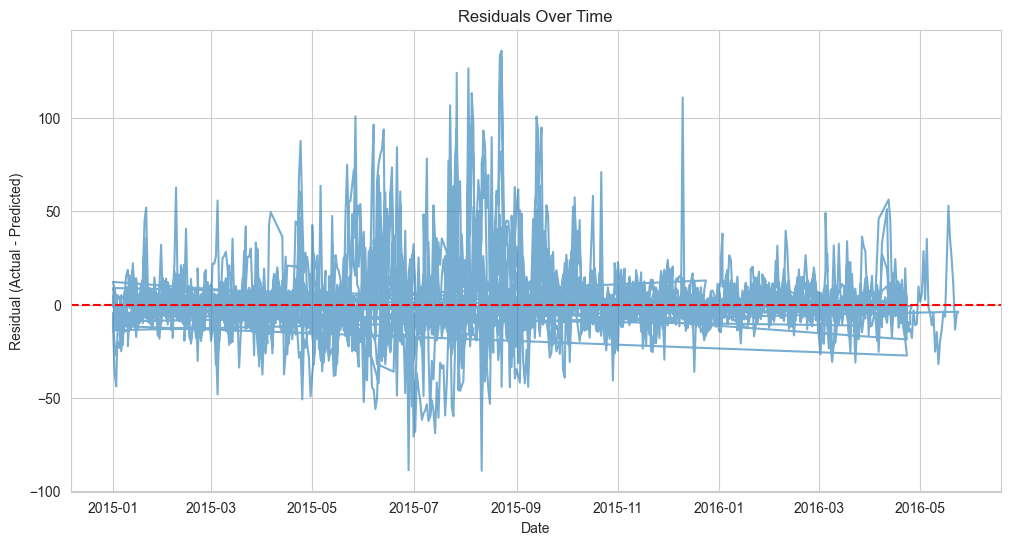

In [135]:
plt.figure(figsize=(12, 6))
plt.plot(test_with_preds["Date Local"], test_with_preds["Residual"], alpha=0.6)
plt.axhline(0, color="red", linestyle="--")
plt.title("Residuals Over Time")
plt.xlabel("Date")
plt.ylabel("Residual (Actual - Predicted)")
plt.show()

---

---

# Push files to Repo

* In cases where you don't need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.